Naive Mean Model: 0.3910417715148465
Baseline Logistic Regression: 0.7539003522898843


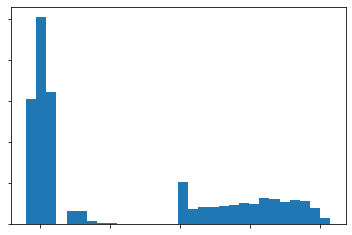

In [63]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsRegressor


from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.impute import KNNImputer

np.random.seed(109)

X_data = pd.read_csv('NHANESI_X.csv')
y_data = pd.read_csv('NHANESI_y.csv')

X_data = X_data.drop('Unnamed: 0', axis = 1)
y_data = y_data.drop('Unnamed: 0', axis = 1)

plt.hist(x=y_data.values, bins=30)

y_data['y'] = (abs(y_data['y'])>=18)*1

X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2,  random_state = 109, shuffle=True, stratify=y_data['y']
)

X_data.head()
y_data.head()

combined = pd.concat([X_data, y_data], axis = 1)
combined_dropped = combined.dropna()

X_data_dropped = combined_dropped[['Age', 'Diastolic BP', 'Poverty index', 'Race', 'Red blood cells',
       'Sedimentation rate', 'Serum Albumin', 'Serum Cholesterol',
       'Serum Iron', 'Serum Magnesium', 'Serum Protein', 'Sex', 'Systolic BP',
       'TIBC', 'TS', 'White blood cells', 'BMI', 'Pulse pressure']]
y_data_dropped = combined_dropped[['y']]


# impute X_data with KNN imputer, n_neighbors = 1

imputer = KNNImputer(n_neighbors=1)
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.fit_transform(X_test)

# turn it into a dataframe, rename columns
X_train_impute = pd.DataFrame(X_train_imputed, columns = X_data.columns)
X_test_impute = pd.DataFrame(X_test_imputed, columns = X_data.columns)

y_train = pd.DataFrame(y_train.values, columns = y_data.columns)
y_test = pd.DataFrame(y_test.values, columns = y_data.columns)

train_imputed = pd.concat([X_train_impute, y_train], axis = 1)
test_imputed = pd.concat([X_test_impute, y_test], axis = 1)

train_imputed.head()

X_train_impute.columns

train_sex = X_train_impute['Sex'].subtract(1)
X_train_impute['Sex'] = train_sex

test_sex = X_test_impute['Sex'].subtract(1)
X_test_impute['Sex'] = test_sex

train_race = X_train_impute['Race'].subtract(1)
X_train_impute['Race'] = train_race

test_race = X_test_impute['Race'].subtract(1)
X_test_impute['Race'] = test_race

X_train_impute.head()



# Baseline KNN regression model on dropped data
baseline_kNN_model = KNeighborsClassifier(n_neighbors=len(X_train_impute)).fit(X_train_impute,y_train.values.ravel())
    
y_pred = baseline_kNN_model.predict(X_test_impute)

baseline_kNN_model_accuracy = mean_squared_error(y_pred,y_test)
print("Naive Mean Model:", baseline_kNN_model_accuracy)

# Logistic regression model on dropped data
logit_base = LogisticRegression(max_iter=10000).fit(X_train_impute,y_train.values.ravel())
y_pred = logit_base.predict(X_test_impute)

logit_base_test_accuracy = accuracy_score(y_pred,y_test)
print("Baseline Logistic Regression:", logit_base_test_accuracy)

## Single Decision Tree (Depth Chose via Cross-Val)

In [64]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

depths = list(range(1, 51))

def calc_meanstd(X_train, y_train, depths):
    train_scores = []
    cvmeans = []
    cvstds = []
    
    for depth in depths:
        dtree = DecisionTreeClassifier(max_depth=depth)
        dtree.fit(X_train, y_train)
        train_score = dtree.score(X_train, y_train)
        scores = cross_val_score(dtree, X_train, y_train, cv=5)
        train_scores.append(train_score)
        cvmeans.append(scores.mean())
        cvstds.append(scores.std())
        
    cvmeans = np.array(cvmeans)
    cvstds = np.array(cvstds)
    
    return cvmeans, cvstds, train_scores

cvmeans, cvstds, train_scores = calc_meanstd(X_train_impute, y_train.values.ravel(), depths)


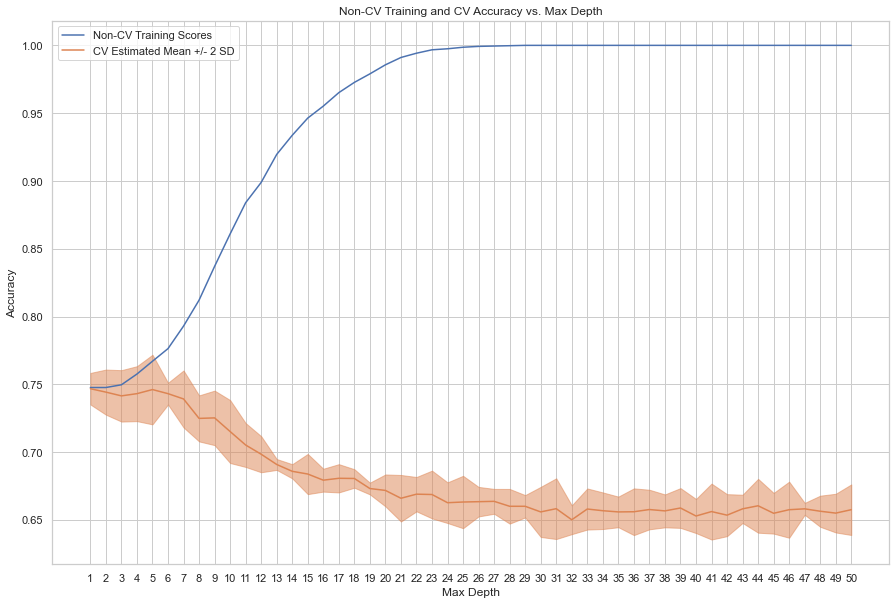

In [65]:
import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

plt.figure(figsize=(15,10))
plt.plot(depths, train_scores, label="Non-CV Training Scores")
plt.plot(depths, cvmeans, label="CV Estimated Mean +/- 2 SD")
plt.fill_between(depths, cvmeans - 2*cvstds, cvmeans + 2*cvstds, color="C1", alpha=0.5)
plt.legend()
plt.title("Non-CV Training and CV Accuracy vs. Max Depth")
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.xticks(depths);

In [66]:
dtree_5 = DecisionTreeClassifier(max_depth=5).fit(X_train_impute, y_train.values.ravel())
best_cv_tree_train_score = dtree_5.score(X_train_impute, y_train.values.ravel())
best_cv_tree_test_score = dtree_5.score(X_test_impute, y_test)
display((best_cv_tree_train_score, best_cv_tree_test_score))
                                        

(0.7670232850849591, 0.7458480120785104)

### Interpretation

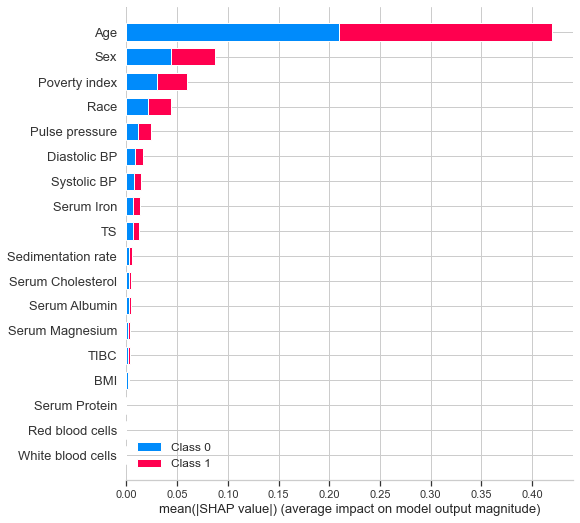

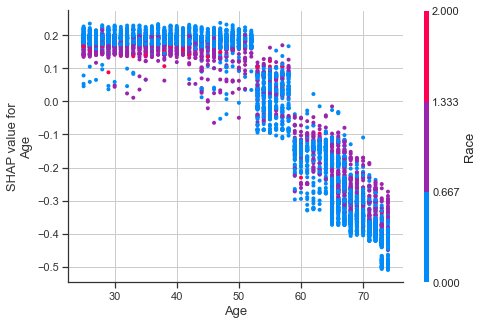

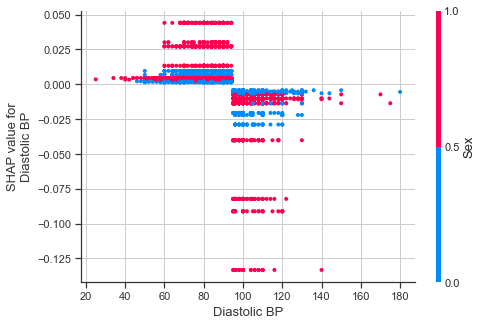

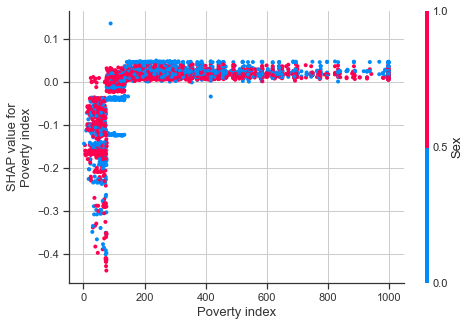

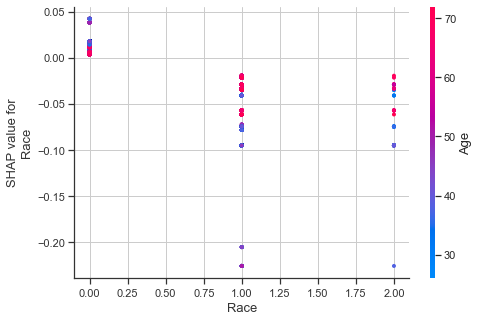

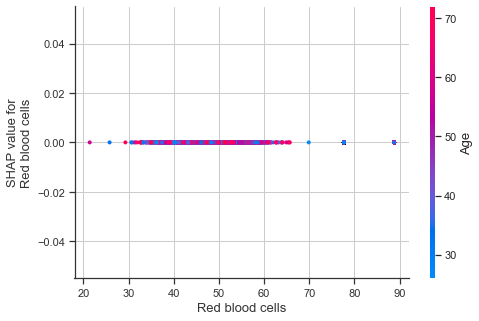

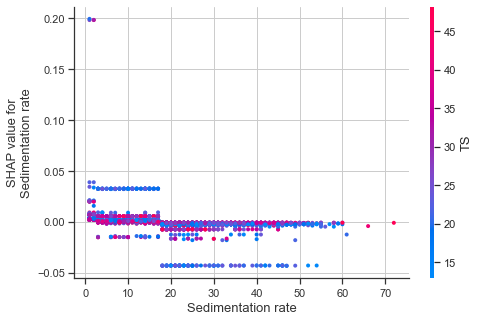

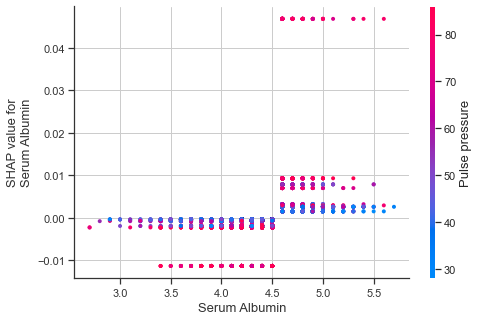

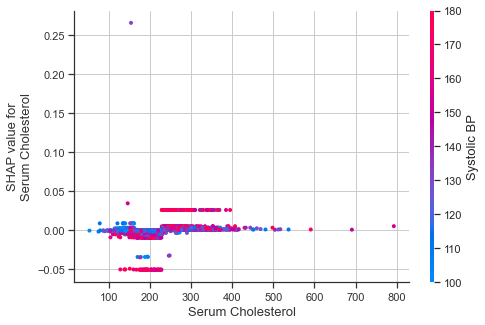

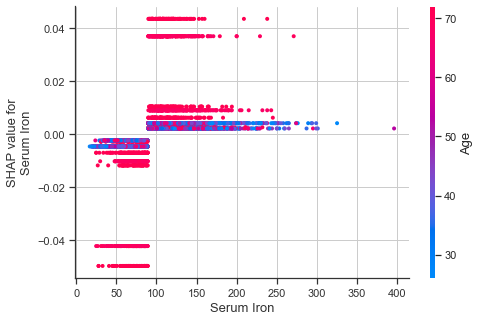

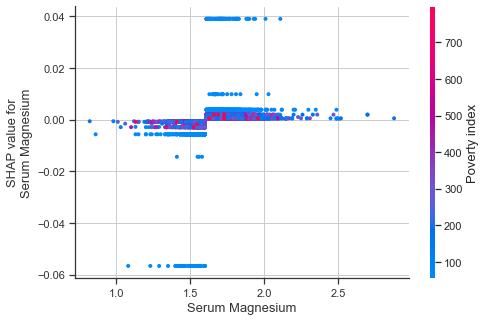

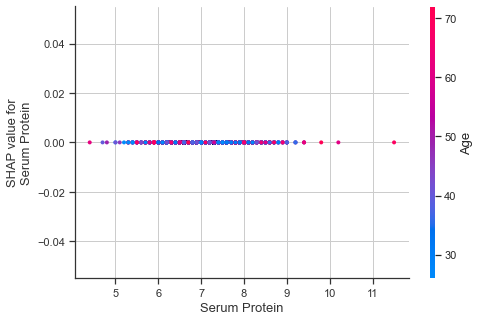

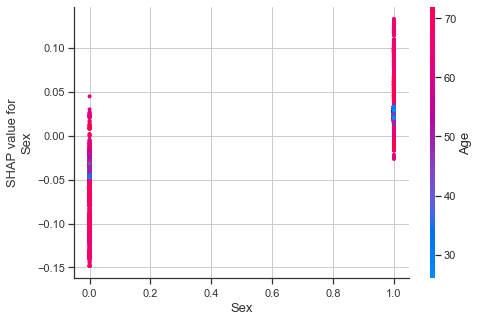

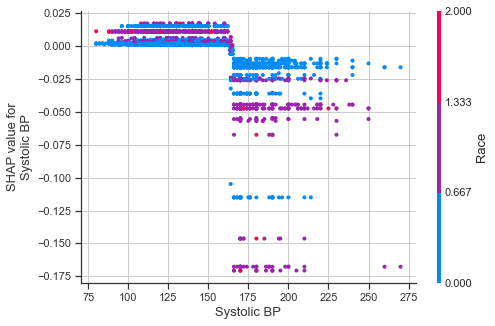

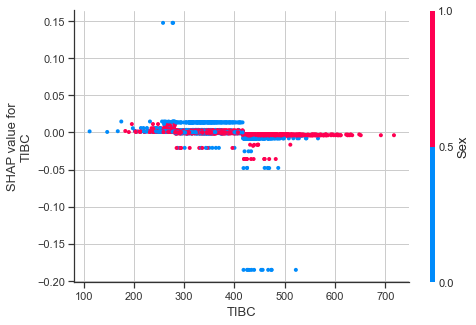

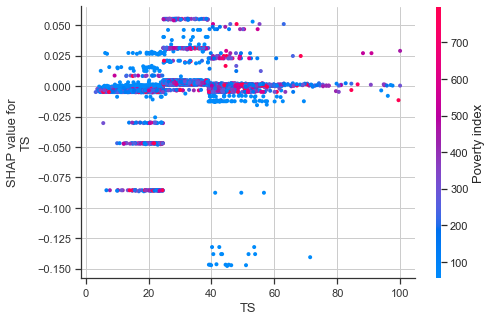

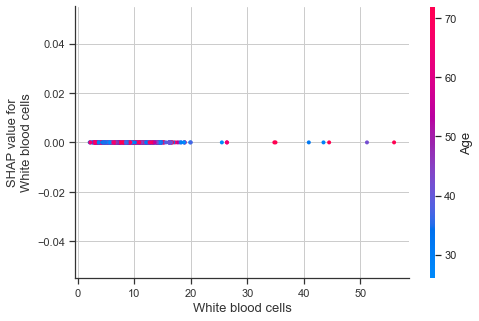

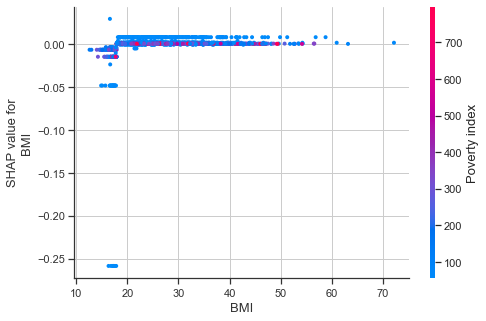

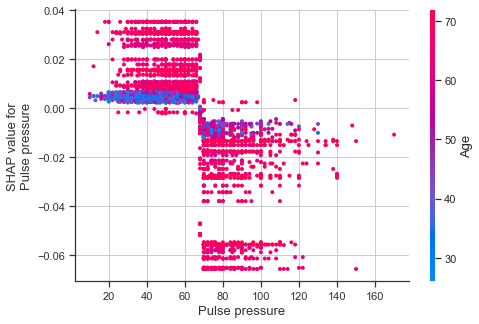

In [105]:
import shap

shap_values = shap.TreeExplainer(dtree_5).shap_values(X_train_impute)
shap.summary_plot(shap_values, X_train_impute, plot_type="bar")
# display(shap_values)
# shap.dependence_plot("Age", shap_values[1], X_train_impute)
# shap.dependence_plot("Systolic BP", shap_values[1], X_train_impute)
# shap.dependence_plot("Sex", shap_values[1], X_train_impute)
# shap.dependence_plot("Poverty index", shap_values[1], X_train_impute)
# shap.dependence_plot("White blood cells", shap_values[1], X_train_impute)

for i in range(18):
    shap.dependence_plot(X_train.columns[i], shap_values[1], X_train_impute)
    

## Decision Trees with Bagging: 

Best Bagging Model Accuracy on Train: 
0.7516108660211049

 Best Bagging Model Accuracy on Test: 
0.7248949658040568


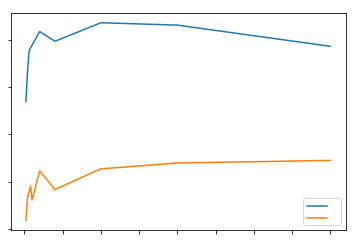

In [59]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree_depth = 5
model_counts = [1,2,3,4,5,10,20,50,100,200]
train_scores = {}
test_scores = {}

for model_count in model_counts:
    bagging_model = BaggingClassifier(DecisionTreeClassifier(max_depth=tree_depth, random_state=69), 
                                      n_estimators=model_count)

    bagging_model.fit(X_train_impute, y_train.values.ravel())

    y_pred_train = bagging_model.predict(X_train_impute)
    y_pred_test = bagging_model.predict(X_test_impute)

    bagging_model_train_accuracy = roc_auc_score(y_train, y_pred_train)
    bagging_model_test_accuracy = roc_auc_score(y_test, y_pred_test)
    
    train_scores[model_count] = bagging_model_train_accuracy
    test_scores[model_count] = bagging_model_test_accuracy

    
best_count = max(test_scores, key=test_scores.get)
bagging_model = BaggingClassifier(DecisionTreeClassifier(max_depth=tree_depth, random_state=69), 
                                      n_estimators=best_count)

bagging_model.fit(X_train_impute, y_train.values.ravel())

y_pred_train = bagging_model.predict(X_train_impute)
y_pred_test = bagging_model.predict(X_test_impute)

bagging_model_train_accuracy = roc_auc_score(y_train, y_pred_train)
bagging_model_test_accuracy = roc_auc_score(y_test, y_pred_test)

print("Best Bagging Model Accuracy on Train: ")
print(bagging_model_train_accuracy)
print("\n Best Bagging Model Accuracy on Test: ")
print(bagging_model_test_accuracy)

num_trees = list(model_counts)

fig = plt.figure(1)
plt.plot(num_trees, list(train_scores.values()), label = "Train Accuracy")
plt.plot(num_trees, list(test_scores.values()), label = "Test Accuracy")
plt.legend()
plt.title("Model Accuracy vs. Number of Bootstrapped Trees")
plt.ylabel("ROC AUC")
plt.xlabel("Number of Trees")
plt.show()


## Interpretation

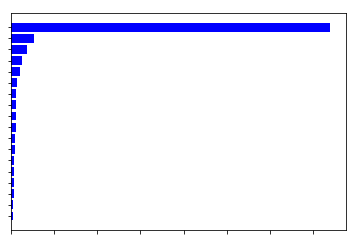

In [60]:
importances = np.mean([tree.feature_importances_ for tree in bagging_model.estimators_], axis=0)
indices = np.argsort(importances)

features = X_train_impute.columns

fig = plt.figure(2)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


In [62]:
import shap

shap_values = shap.AdditiveExplainer(bagging_model).shap_values(X_train_impute)


TypeError: __init__() missing 1 required positional argument: 'masker'